In [360]:
import numpy as np
import math
import copy
import numpy.linalg as LA
import time
import random
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

# Classification

In [361]:
ambientDimension = 100
sigma = 0.5 # noise power
numAvg = int(1 * 1e+1) # number of average
base_train_num = 100

featureMean = np.zeros(ambientDimension)

# Testing Isotropic data 
a_test = 1
Cov1, Cov2 = np.identity(ambientDimension), np.identity(ambientDimension)
decay = .95
for i in range(ambientDimension):
    Cov1[i, i] = decay ** (i - 1)
for i in range(ambientDimension)[::-1]:
    Cov2[i, i] = decay ** (i - 1)
#for i in range(ambientDimension):
#    if i <= int(ambientDimension/2):
#        Cov1[i, i] = 0
#    else:
#        Cov2[i, i] = 0


featureCov = a_test * Cov1 + (1 - a_test) * Cov2
# sparse signal
#p = 0.2
#diag = np.diag(np.diag(featureCov))
#featureCov = (1 - p) ** 2 * (featureCov - diag) + (1 - p) * diag

#featureCov = np.identity(ambientDimension)
betaStar = np.random.multivariate_normal(featureMean, featureCov).reshape(-1,1)
betaStar /= LA.norm(betaStar)

#betaStar = np.ones([ambientDimension, 1])
#for i in range(ambientDimension):
#    if i <= int(ambientDimension/2):
#        betaStar[i, 0] = -1
#betaStar /= LA.norm(betaStar)

# sparsity
#for i in range(ambientDimension):
#    a = random.random()
#    if a <= 0.9:
#        betaStar[i] = 0
#betaStar /= LA.norm(betaStar)
        

# Nonisotropic data (comment this block if istropic data is used)
#featureCov = np.identity(ambientDimension)
#for i in range(ambientDimension):
#    if i <= int(ambientDimension/2):
#        featureCov[i,i] = 1
#betaStar =  np.zeros(ambientDimension).reshape(-1,1)
#betaStar[0] = 0.1
#betaStar[-1] = 1

# training data
train_mean = np.zeros(ambientDimension)
a_train = 1
#train_cov = np.identity(ambientDimension)
#for i in range(ambientDimension):
#    if i <= int(ambientDimension/2):
#        train_cov[i,i] = 0.2

In [362]:
# Estimator Function
def getRidgeEst(X, y, yc, ridge):
    d = X.shape[1]
    n = X.shape[0]
    idm = np.identity(d)
    #for i in range(ambientDimension):
    #    if i <= int(ambientDimension/2):
    #        idm[i, i] = 0

    S = LA.pinv(X.T.dot(X) + n * ridge * idm).dot(X.T)
    return S.dot(y), S.dot(yc)

def getLSEst(X, y):
    Cov = X.T.dot(X)
    #d = X.shape[1]
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    S = LA.pinv(Cov).dot(X.T)
    return S.dot(y)

def getCropEst(X, y, yc, p):
    Cov = X.T.dot(X)
    d, n = X.shape[1], X.shape[0]
    diag = np.diag(np.diag(Cov))
    #Cov = n * featureCov
    a = 0
    Z = a * Cov + (1 - a) * ((1-p) * Cov + p * diag)
    
    #d, n = X.shape[1], X.shape[0]
    #ridge = 0.1
    #Z = Z + n * ridge * np.identity(d)
    
    S = LA.pinv(Z).dot((1 - p) * X.T)
    return S.dot(y), S.dot(yc) 

def get_crop_finite_iter(X, n0, n1, p):
    X0 = copy.deepcopy(X)
    x = X[n1 % n0, :] * bernoulli.rvs(1-p, size=ambientDimension)
    X0 = np.concatenate((X0, x.reshape(1, -1)), axis=0)
    return X0
    
def get_crop_finite_data(X, y, n1, p):
    n0 = X.shape[0]
    X0 = copy.deepcopy(X)
    y0 = copy.deepcopy(y)
    for i in range(n1):
        x = X0[i % n0, :] * bernoulli.rvs(1-p, size=ambientDimension)
        y1 = y0[i % n0, :]
        X0 = np.concatenate((X0, x.reshape(1, -1)), axis=0)
        y0 = np.concatenate((y0, y1.reshape(1, -1)), axis=0)
    return X0, y0

def get_gauss_finite_data(X, y, n1, ridge):
    n0 = X.shape[0]
    X0 = copy.deepcopy(X)
    y0 = copy.deepcopy(y)
    for i in range(n1):
        x = X0[i % n0, :] + ridge * np.random.multivariate_normal(np.zeros(ambientDimension), np.identity(ambientDimension))
        y1 = y0[i % n0, :]
        X0 = np.concatenate((X0, x.reshape(1, -1)), axis=0)
        y0 = np.concatenate((y0, y1.reshape(1, -1)), axis=0)
    return X0, y0
    
# Uitlity Functions

def getMask(k, p):
    mean_mask = 0
    for i in range(k):
        mean_mask += bernoulli.rvs(1-p, size=ambientDimension)
    return mean_mask / k

# Risk

def getRisk(beta, X_test, y_test):
    risk = 0
    num_test = X_test.shape[0]
    for i in range(num_test):
        if y_test[i] * (np.inner(X_test[i, :], beta.reshape(-1))) < 0:
            risk += 1
        elif y_test[i] * (np.inner(X_test[i, :], beta.reshape(-1))) == 0:
            risk += 0.5
    risk /= num_test
    return risk

def get_risk(beta):
    z = np.inner(beta.reshape(-1), betaStar.reshape(-1)) / math.sqrt(2) / math.sqrt(beta.T.dot(featureCov).dot(beta)[0])
    return 0.5 * (1 - math.erf(z))

def getExpRisk(numSampling, numIter, paraList, modeDA):
    risk = np.zeros([numIter, len(paraList)])
    riskLSE = np.zeros(numIter)
            
    for t in range(numIter):
        X = np.zeros([numSampling, ambientDimension])
        y = np.zeros([numSampling, 1])
        for i in range(numSampling):
            z = random.random()
            y[i, 0] = -1 if z <= 0.5 else 1
            X[i, :] = (betaStar * y[i, 0] + np.random.multivariate_normal(np.zeros(ambientDimension), featureCov).reshape(-1, 1)).reshape(-1)
        X0 = X[:base_train_num, :] # base sample
        y0 = y[:base_train_num, :]
        
        # generate test data
        #num_test = 100
        #y_test = np.zeros(num_test)
        #X_test = np.zeros([num_test, ambientDimension])
        #for j in range(num_test):
        #    z = random.random()
        #    y_test[j] = -1 if z <= 0.5 else 1
        #    X_test[j, :] = (betaStar * y_test[j] + np.random.multivariate_normal(np.zeros(ambientDimension), featureCov).reshape(-1, 1)).reshape(-1)
        
        # baseline LSE
        beta_est = getLSEst(X, y)
        riskLSE[t] = get_risk(beta_est)
        
        for j in range(len(paraList)):
            if numSampling > base_train_num:
                n1 = numSampling - base_train_num
                if modeDA == "crop":
                    X1, y1 = get_crop_finite_data(X0, y0, n1, paraList[j])
                elif modeDA == "ridge":
                    X1, y1 = get_gauss_finite_data(X0, y0, n1, paraList[j]) 
            else:
                X1, y1 = X, y
           
            beta_est = getLSEst(X1, y1)
            risk[t, j] = get_risk(beta_est)
    return risk.mean(axis=0), riskLSE.mean()

In [363]:
# Choose the type of augmentation:
mode = "ridge"
param = 0

# set range of parameters of DA
# "crop_finite": dropout with k fixed patterns, "crop": dropout with p dropout rate, 
# "ridge": add gaussian with power sigma s^2, "proj": random projection with k dimensional space,
# "mixup": mix-up with beta distribution parameter b
if mode == "ridge":
    params = np.power(2, np.linspace(-10, 10, num=10))
elif mode == "crop":
    params = np.concatenate((np.linspace(0, 0.4, num=4), np.linspace(.5, 1, num=5)))
elif mode == "crop_finite":
    params = np.power(10, np.linspace(1, 2, 5)).astype(int)
elif mode == "proj":
    lowD = ambientDimension * (1-np.power(2, np.linspace(-4, -0.1 , 10)))
    params = [round(num) for num in lowD]
elif mode == "mixproj":
    params = np.power(2, np.linspace(-8, -1.5 , 10))
elif mode == "mixup":
    params = np.power(2, np.linspace(-3, 5 , 10))
elif mode == "mixOT":
    params = np.power(2, np.linspace(-3, 5 , 10))

In [364]:
sample = range(5, 4 * ambientDimension, 20)
riskList = list()
riskLseList = list()

# Simulate risk
np.random.seed(1)
count = 0
start = time.time()
for i in sample:
    a, b = getExpRisk(i, numAvg, params, mode)
    riskList.append(a)
    riskLseList.append(b)
    count += 1
    print('Complete {} %'.format(round(count*100/len(sample), 1)))
end = time.time()
print('Complete in {} sec'.format(round(end-start, 2)))

Complete 5.0 %
Complete 10.0 %
Complete 15.0 %
Complete 20.0 %
Complete 25.0 %
Complete 30.0 %
Complete 35.0 %
Complete 40.0 %
Complete 45.0 %
Complete 50.0 %
Complete 55.0 %
Complete 60.0 %
Complete 65.0 %
Complete 70.0 %
Complete 75.0 %
Complete 80.0 %
Complete 85.0 %
Complete 90.0 %
Complete 95.0 %
Complete 100.0 %
Complete in 192.39 sec


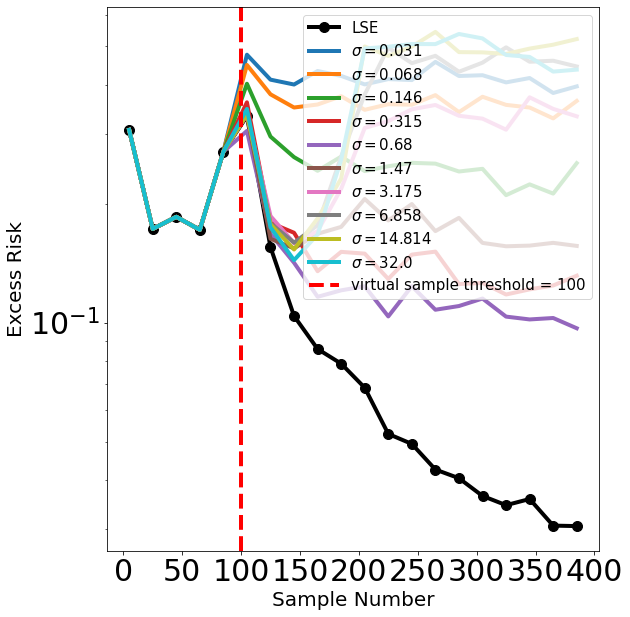

In [365]:
riskTable = np.zeros([len(sample),len(params)])
for i in range(len(sample)):
    for j in range(len(params)):
        riskTable[i,j] = riskList[i][j]

plt.figure(figsize=(30, 10))
plt.subplot(1,3,1)
plt.plot(sample, riskLseList, label="LSE", color='black', marker='o', markersize=10, linewidth=4.0) 
for i in range(0, len(params)):
    if mode == "ridge":
        plt.plot(sample, riskTable[:,i],label=r'$\sigma=$'+str(round(np.sqrt(params[i]),3)), linewidth=4.0) # Gaussian noise
    elif mode == "crop":
        plt.plot(sample, riskTable[:,i],label=r'$p=$'+str(round(params[i],3)), linewidth=4.0) # Random crop
    elif mode == "crop_finite":
        plt.plot(sample, riskTable[:,i],label=r'$k=$'+str(round(params[i],3)), linewidth=4.0) # Random crop
    elif mode == "proj":
        plt.plot(sample, riskTable[:,i],label=r'$k=$'+str(round(params[i])), linewidth=4.0) # Random projection
    elif mode == "mixproj":
        plt.plot(sample, riskTable[:,i],label=r'$\alpha=$'+str(round(1-params[i], 3)), linewidth=4.0) # Random mixup projection    
    elif mode == "mixup":
        plt.plot(sample, riskTable[:,i],label=r'$\alpha=$'+str(round(params[i], 3)), linewidth=4.0) # Random mixup projection 
    elif mode == "mixOT":
        plt.plot(sample, riskTable[:,i],label=r'$\alpha=$'+str(round(params[i], 3)), linewidth=4.0) # OT + Random mixup projection
    plt.yscale("log")   
plt.axvline(x=base_train_num, label='virtual sample threshold = ' + str(base_train_num), c='red', ls='--', linewidth=4.0)
plt.legend(loc="upper right", prop={'size': 15})
plt.xlabel('Sample Number', fontsize=20)
plt.ylabel('Excess Risk', fontsize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#plt.ylim(1e-2,1e2)

plt.show()

In [366]:
betaStar.shape

(100, 1)

In [367]:
Cov2

array([[1.05263158, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.95      , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00726886, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00690541,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00656014]])

In [368]:
int((upper - lower) / 5)

0

In [369]:
riskList

[array([0.30719537, 0.30719537, 0.30719537, 0.30719537, 0.30719537,
        0.30719537, 0.30719537, 0.30719537, 0.30719537, 0.30719537]),
 array([0.17256466, 0.17256466, 0.17256466, 0.17256466, 0.17256466,
        0.17256466, 0.17256466, 0.17256466, 0.17256466, 0.17256466]),
 array([0.18511949, 0.18511949, 0.18511949, 0.18511949, 0.18511949,
        0.18511949, 0.18511949, 0.18511949, 0.18511949, 0.18511949]),
 array([0.17165607, 0.17165607, 0.17165607, 0.17165607, 0.17165607,
        0.17165607, 0.17165607, 0.17165607, 0.17165607, 0.17165607]),
 array([0.27051209, 0.27051209, 0.27051209, 0.27051209, 0.27051209,
        0.27051209, 0.27051209, 0.27051209, 0.27051209, 0.27051209]),
 array([0.4759863 , 0.44844276, 0.40192887, 0.36074599, 0.30539311,
        0.33442236, 0.33667346, 0.34109208, 0.33642379, 0.34717022]),
 array([0.4116284 , 0.37794347, 0.29545742, 0.1788168 , 0.16770088,
        0.16285355, 0.18600244, 0.17835869, 0.17726699, 0.17416303]),
 array([0.40014209, 0.34997389, 0.

In [370]:
riskLseList

[0.3071953700057113,
 0.17256466234073678,
 0.1851194892644656,
 0.1716560684869312,
 0.27051209485294375,
 0.3326615992240316,
 0.1550862437759589,
 0.1038995331702183,
 0.08573054435198245,
 0.07871115713528895,
 0.06842223855659305,
 0.05227860037619756,
 0.049314976437690825,
 0.04248087323004478,
 0.04038923330220841,
 0.03642826980472403,
 0.034519196750151714,
 0.03578034312217208,
 0.030645637286433974,
 0.03055968882086656]

In [371]:
np.random.multivariate_normal(np.zeros(ambientDimension), featureCov).reshape(-1, 1)


array([[-0.18967746],
       [-0.26583241],
       [-1.09946486],
       [-0.73325075],
       [-0.84280346],
       [ 1.14125189],
       [-0.03162752],
       [ 0.79452132],
       [-0.83478668],
       [-0.50137152],
       [ 0.89887797],
       [-0.19224919],
       [-0.33693075],
       [-0.16558989],
       [ 0.11642051],
       [-0.95895935],
       [-0.73699297],
       [ 0.8362685 ],
       [ 0.53555193],
       [ 0.81082546],
       [-0.88372642],
       [ 1.52970641],
       [-0.40879749],
       [-0.00596509],
       [-0.7585606 ],
       [-0.04897765],
       [ 0.35812607],
       [ 0.23903116],
       [-0.09017304],
       [-0.1413916 ],
       [-0.12915433],
       [-0.14673668],
       [ 0.48685858],
       [ 0.12971095],
       [ 0.70066558],
       [ 0.20230643],
       [ 0.08321609],
       [-0.2590985 ],
       [ 0.17285038],
       [-0.08595705],
       [ 0.24251416],
       [-0.17051421],
       [-0.14520761],
       [-0.82944133],
       [ 0.11155298],
       [-0